In [3]:
!pip3 install pandas numpy matplotlib statsmodels scikit-learn xgboost requests coinmetrics-api-client tensorflow --break-system-packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import sklearn
import requests
from coinmetrics.api_client import CoinMetricsClient
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
client = CoinMetricsClient()
catalog_response = client.catalog_asset_metrics_v2("btc").to_list()
metric_names = [catalog_response[0]['metrics'][i]['metric'] for i in range(len(catalog_response[0]['metrics']))]
 # asset_metrics = client.get_asset_metrics(
 #            assets="btc",
 #            metrics=metric_names,
 #            frequency="1b",
 #            paging_from=PagingFrom.START,
 #            page_size=1000
 #        )


## Data Source Information

Data has been downloaded from: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data
This data is the very latest and up to date and is updated daily by a scraper: https://github.com/mczielinski/kaggle-bitcoin/
This dataset contains per minute OHLCV data for BTC from Jan 2012 - Present.
The scraper uses Bitstamp API to fetch this data. **Bitstamp** is known to be a very reliable and secure crypto exchange platform. Hence, we can consider this to be a good data source for our use case.


In [7]:
data = pd.read_csv('btcusd_1-min_data.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [8]:
df = pd.DataFrame(data)
df.info()

print("Summary statistics")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7085971 entries, 0 to 7085970
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 324.4 MB
Summary statistics


,Timestamp,Open,High,Low,Close,Volume
count,7.085971e+06,7.085971e+06,7.085971e+06,7.085971e+06,7.085971e+06,7.085971e+06
mean,1.537993e+09,1.832537e+04,1.833245e+04,1.831807e+04,1.832537e+04,5.253670e+00
std,1.227350e+08,2.553689e+04,2.554480e+04,2.552879e+04,2.553686e+04,2.240655e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.431702e+09,4.292200e+02,4.294300e+02,4.290100e+02,4.292200e+02,1.794391e-02
50%,1.537991e+09,6.730220e+03,6.734020e+03,6.726590e+03,6.730200e+03,4.562457e-01
75%,1.644281e+09,2.818100e+04,2.819000e+04,2.817200e+04,2.818100e+04,3.000000e+00
max,1.750640e+09,1.119930e+05,1.120000e+05,1.119670e+05,1.119750e+05,5.853852e+03


In [9]:
missing_values = df.isnull().sum()
print("Count of missing values per column: ")
missing_values

Count of missing values per column: 


Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

In [10]:
# Convert Timestamp format to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.tail()

,Timestamp,Open,High,Low,Close,Volume
7085966,2025-06-23 00:47:00,101285.0,101355.0,101285.0,101355.0,2.904749
7085967,2025-06-23 00:48:00,101355.0,101641.0,101355.0,101586.0,10.221699
7085968,2025-06-23 00:49:00,101644.0,101644.0,101491.0,101491.0,1.670460
7085969,2025-06-23 00:50:00,101452.0,101452.0,101294.0,101294.0,0.777038
7085970,2025-06-23 00:51:00,101341.0,101357.0,101313.0,101314.0,0.392344


### Resample Data to get daily, monthly and annual dataframes

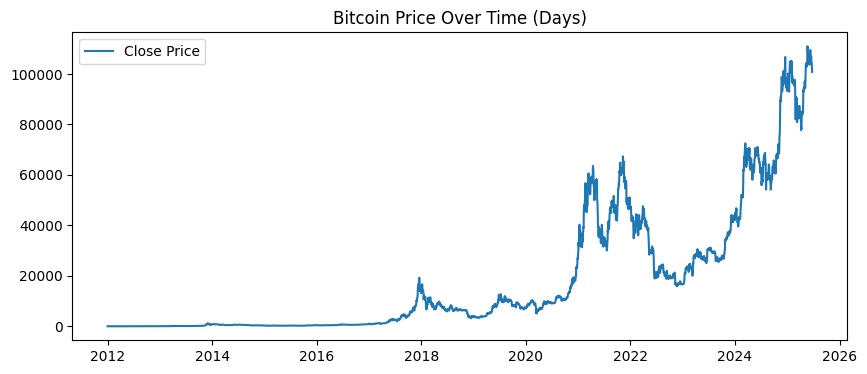

In [11]:
df_daily = df.resample('D', on='Timestamp').mean()

plt.figure(figsize=(10, 4))
plt.plot(df_daily['Close'], label='Close Price')
plt.title('Bitcoin Price Over Time (Days)')
plt.legend()

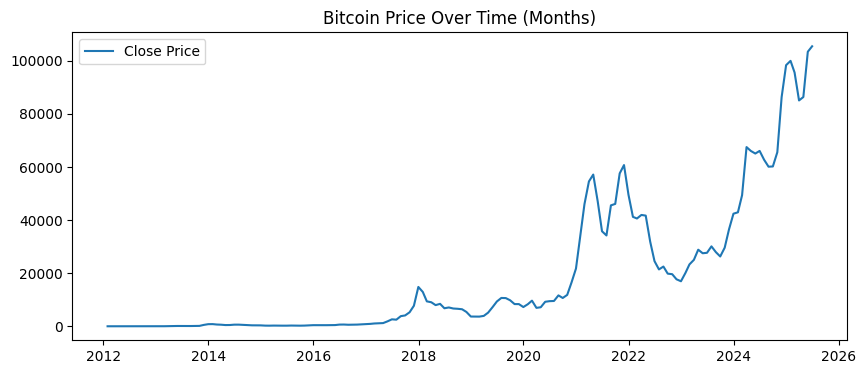

In [12]:
df_monthly = df.resample('ME', on='Timestamp').mean()

plt.figure(figsize=(10, 4))
plt.plot(df_monthly['Close'], label='Close Price')
plt.title('Bitcoin Price Over Time (Months)')
plt.legend()

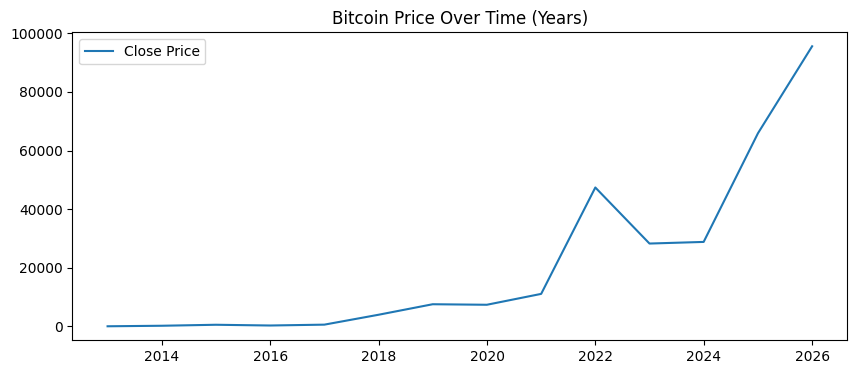

In [13]:
df_annual = df.resample('YE-DEC', on='Timestamp').mean()

plt.figure(figsize=(10, 4))
plt.plot(df_annual['Close'], label='Close Price')
plt.title('Bitcoin Price Over Time (Years)')
plt.legend()

## Feature Engineering

List of features used:
- Close Price
- OHCLV Lags over multiple time periods
- Simple Moving Averages over multiple time periods
- Exponential Moving Averages over multiple time periods
- Relative Strength Index
- Moving Average Convergence Divergence
- Fibonacci Retracement Levels
- On-Balance Volume

List of features that could be added:
- historical volatility data from Volatility index
- on-chain metrics like hashing rate, mining difficulty, etc.

In [14]:
df_features = df_daily[['Close']].copy()

lags = {
    "Close": [1, 3, 7, 14],
    "Open": [1, 3, 7],
    "Volume": [1, 3, 7],
    "High": [1, 3, 7],
    "Low": [1, 3, 7],
}

def create_feature_lags():
    for (key, values) in lags.items():
        for val in values: 
            col_name = f"{key}_lag_{val}"
            df_features[col_name] = df_daily[key].shift(val)
create_feature_lags()
df_features.columns

Index(['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7', 'Close_lag_14',
       'Open_lag_1', 'Open_lag_3', 'Open_lag_7', 'Volume_lag_1',
       'Volume_lag_3', 'Volume_lag_7', 'High_lag_1', 'High_lag_3',
       'High_lag_7', 'Low_lag_1', 'Low_lag_3', 'Low_lag_7'],
      dtype='object')

In [15]:
moving_averages = {
    "SMA" : [1, 7, 14, 30],
    "EMA" : [1, 7, 14, 30]
}

def create_feature_moving_averages():
    for (key, values) in moving_averages.items():
        for val in values:
            col_name = f"{key}_{val}"
            match key:
                case "SMA":
                    df_features[col_name] = df_daily['Close'].rolling(window=val).mean()
                case "EMA": 
                    df_features[col_name] = df_daily['Close'].ewm(span=val, adjust=False).mean()
create_feature_moving_averages()
df_features.columns

Index(['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7', 'Close_lag_14',
       'Open_lag_1', 'Open_lag_3', 'Open_lag_7', 'Volume_lag_1',
       'Volume_lag_3', 'Volume_lag_7', 'High_lag_1', 'High_lag_3',
       'High_lag_7', 'Low_lag_1', 'Low_lag_3', 'Low_lag_7', 'SMA_1', 'SMA_7',
       'SMA_14', 'SMA_30', 'EMA_1', 'EMA_7', 'EMA_14', 'EMA_30'],
      dtype='object')

In [16]:
def compute_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    df_features['RSI'] = rsi
    return df

compute_rsi(df_daily)
df_features.columns

Index(['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7', 'Close_lag_14',
       'Open_lag_1', 'Open_lag_3', 'Open_lag_7', 'Volume_lag_1',
       'Volume_lag_3', 'Volume_lag_7', 'High_lag_1', 'High_lag_3',
       'High_lag_7', 'Low_lag_1', 'Low_lag_3', 'Low_lag_7', 'SMA_1', 'SMA_7',
       'SMA_14', 'SMA_30', 'EMA_1', 'EMA_7', 'EMA_14', 'EMA_30', 'RSI'],
      dtype='object')

In [17]:
def compute_macd(df, fast=12, slow=26, signal=9):
    df_features['EMA_fast'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df_features['EMA_slow'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df_features['MACD'] = df_features['EMA_fast'] - df_features['EMA_slow']
    df_features['Signal_Line'] = df_features['MACD'].ewm(span=signal, adjust=False).mean()
    df_features['MACD_Hist'] = df_features['MACD'] - df_features['Signal_Line']
    return df

compute_macd(df_daily)
df_features.columns

Index(['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7', 'Close_lag_14',
       'Open_lag_1', 'Open_lag_3', 'Open_lag_7', 'Volume_lag_1',
       'Volume_lag_3', 'Volume_lag_7', 'High_lag_1', 'High_lag_3',
       'High_lag_7', 'Low_lag_1', 'Low_lag_3', 'Low_lag_7', 'SMA_1', 'SMA_7',
       'SMA_14', 'SMA_30', 'EMA_1', 'EMA_7', 'EMA_14', 'EMA_30', 'RSI',
       'EMA_fast', 'EMA_slow', 'MACD', 'Signal_Line', 'MACD_Hist'],
      dtype='object')

In [18]:
def compute_bollinger_bands(df, window=20):
    sma = df['Close'].rolling(window).mean()
    std = df['Close'].rolling(window).std()
    df_features['BB_Middle'] = sma
    df_features['BB_Upper'] = sma + 2 * std
    df_features['BB_Lower'] = sma - 2 * std
    return df

compute_bollinger_bands(df_daily)
df_features.columns

Index(['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7', 'Close_lag_14',
       'Open_lag_1', 'Open_lag_3', 'Open_lag_7', 'Volume_lag_1',
       'Volume_lag_3', 'Volume_lag_7', 'High_lag_1', 'High_lag_3',
       'High_lag_7', 'Low_lag_1', 'Low_lag_3', 'Low_lag_7', 'SMA_1', 'SMA_7',
       'SMA_14', 'SMA_30', 'EMA_1', 'EMA_7', 'EMA_14', 'EMA_30', 'RSI',
       'EMA_fast', 'EMA_slow', 'MACD', 'Signal_Line', 'MACD_Hist', 'BB_Middle',
       'BB_Upper', 'BB_Lower'],
      dtype='object')

In [19]:
def compute_obv(df):
    obv = [0]
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
            obv.append(obv[-1] + df['Volume'].iloc[i])
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
            obv.append(obv[-1] - df['Volume'].iloc[i])
        else:
            obv.append(obv[-1])
    df_features['OBV'] = obv
    return df

compute_obv(df_daily)
df_features.columns

Index(['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7', 'Close_lag_14',
       'Open_lag_1', 'Open_lag_3', 'Open_lag_7', 'Volume_lag_1',
       'Volume_lag_3', 'Volume_lag_7', 'High_lag_1', 'High_lag_3',
       'High_lag_7', 'Low_lag_1', 'Low_lag_3', 'Low_lag_7', 'SMA_1', 'SMA_7',
       'SMA_14', 'SMA_30', 'EMA_1', 'EMA_7', 'EMA_14', 'EMA_30', 'RSI',
       'EMA_fast', 'EMA_slow', 'MACD', 'Signal_Line', 'MACD_Hist', 'BB_Middle',
       'BB_Upper', 'BB_Lower', 'OBV'],
      dtype='object')

## Model Building I: ARIMA

In [20]:
target = 'Close'

### Step 1: Test for stationarity with ADF 

In [21]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_features[target])
print(f'p-value: {result[1]}')  # p < 0.05 = stationary

p-value: 0.9491023887769414


There is a clear upward trend and the p-value is above 0.5 indicating that the data is not stationary, so we apply level 1 differencing and check again.

ADF Statistic: -10.186156679479723
p-value: 6.5005624143410276e-18


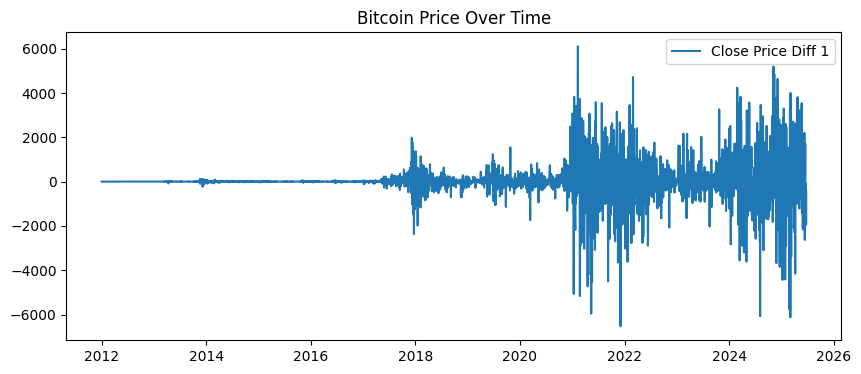

In [22]:
df_features['Close_diff_1'] = df_features['Close'].diff()
result = adfuller(df_features['Close_diff_1'].dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

plt.figure(figsize=(10, 4))
plt.plot(df_features['Close_diff_1'], label='Close Price Diff 1')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()

The p-value is much lower than 0.5 confirming that the data is now stationary. Now we know that the mean is stabilized for this data, time to apply log to the closing diff to make the variance stable as well.

ADF Statistic: -10.665165168692212
p-value: 4.30594595896931e-19


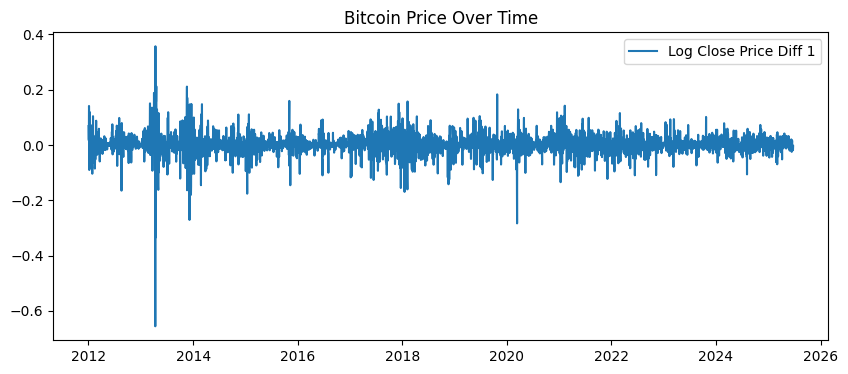

In [23]:
df_features['Log_Close'] = np.log(df_features['Close'])
df_features['Log_Close_diff_1'] = df_features['Log_Close'].diff()
result = adfuller(df_features['Log_Close_diff_1'].dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

plt.figure(figsize=(10, 4))
plt.plot(df_features['Log_Close_diff_1'], label='Log Close Price Diff 1')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()

### Step 2: Finding p and q values for the AR and MA parameters of ARIMA using PACF and ACF graphs

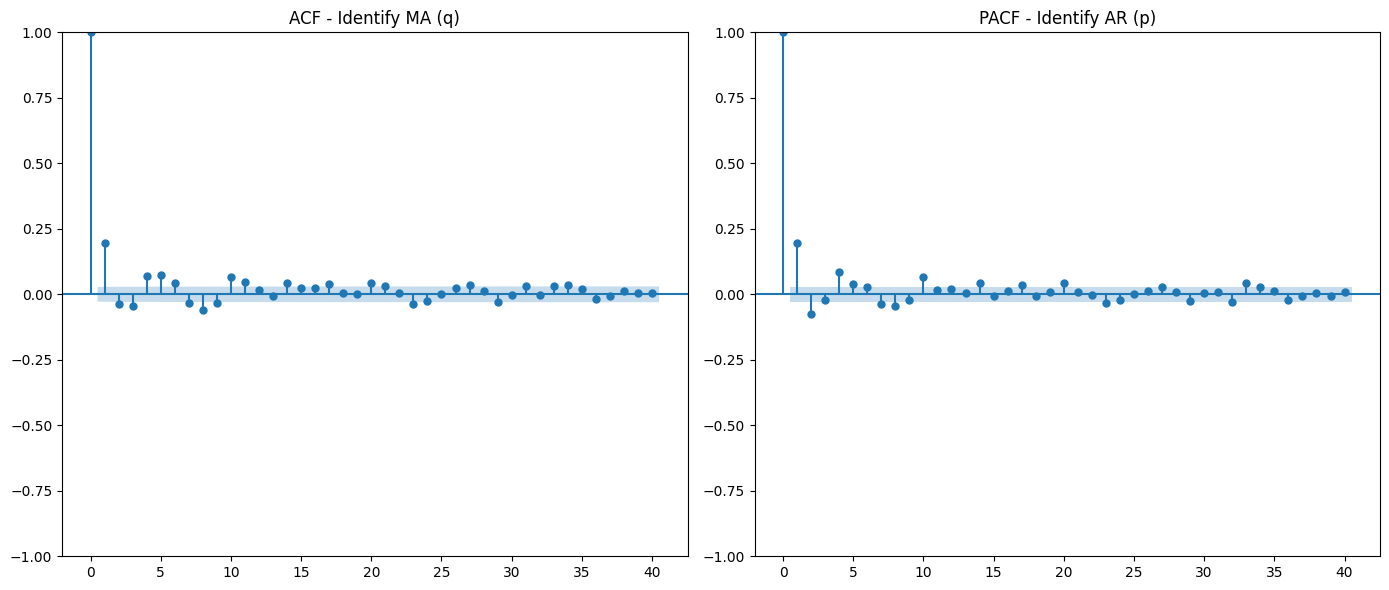

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Drop NaNs from differencing
log_diff = df_features['Log_Close_diff_1'].dropna()

plt.figure(figsize=(14, 6))

# ACF Plot (for MA -> q)
plt.subplot(1, 2, 1)
plot_acf(log_diff, lags=40, ax=plt.gca())
plt.title("ACF - Identify MA (q)")

# PACF Plot (for AR -> p)
plt.subplot(1, 2, 2)
plot_pacf(log_diff, lags=40, method='ywm', ax=plt.gca())
plt.title("PACF - Identify AR (p)")

plt.tight_layout()
plt.show()

We see only one significant spike at t=1 and thus our p=q=1

### Step 3: Split training and testing data (80/20)

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

p = 1
q = 1
d = 1

data = log_diff

train_fraction = 0.8
train_len = int(train_fraction * len(data))
train = data.iloc[:train_len]
test = data.iloc[train_len:]

### Step 4: Train the model and predict on test data

In [26]:
model = ARIMA(train, order=(p, d, q))  # (p,d,q)
model_fit = model.fit()

prediction = model_fit.forecast(steps=len(test)) 

/Users/akshat31/Development/CryptoChakra/crypto-env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/akshat31/Development/CryptoChakra/crypto-env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/akshat31/Development/CryptoChakra/crypto-env/lib/python3.10/site-packages/numpy/linalg/_linalg.py:3437: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


In [37]:
# Invert log to get actual price forecast
last_observed_price = df_features['Close'].iloc[train_len - 1]
forecast_prices = np.exp(prediction.cumsum() + np.log(last_observed_price))

# Align test true values
actual_prices = df_features['Close'].iloc[train_len:train_len + len(forecast_prices)]

### Step 5: Analyze accuracy using different metrics

In [76]:
mae = mean_absolute_error(actual_prices, forecast_prices)
mape = mean_absolute_percentage_error(actual_prices, forecast_prices)
directional_accuracy = (np.sign(np.diff(forecast_prices)) == np.sign(np.diff(actual_prices.values))).mean()
rmse = np.sqrt(mean_squared_error(actual_prices, forecast_prices))
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"Directional Accuracy: {directional_accuracy:.2%}")

RMSE: 56434.90
MAE: 46096.60
MAPE: 74.48%
Directional Accuracy: 46.85%


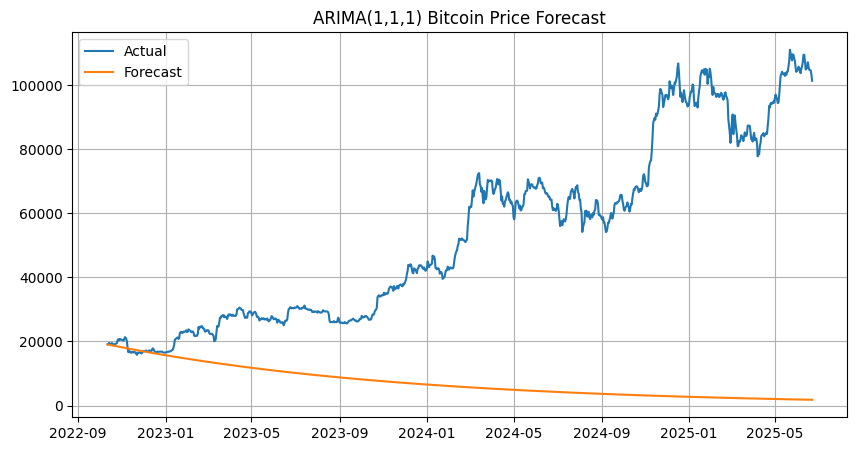

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(actual_prices.index, actual_prices.values, label="Actual")
plt.plot(actual_prices.index, forecast_prices.values, label="Forecast")
plt.title("ARIMA(1,1,1) Bitcoin Price Forecast")
plt.legend()
plt.grid()
plt.show()

ARIMA predictions for Bitcoin tend to have a bad reputation and a high error value since these models cannot learn the non-linear relationships in the cryptocurrency data. ARIMA also assumes a linear relationship between past and future data, which may not always be true for this market. ARIMA also considers only one feature i.e. the past closing prices. Not considering other qualitative ƒactors like market sentiment and other technical indicators make it a weak model. Bitcoin data is non-stationary as well and differencing might remove meaningful patterns in this data.

### Checking training accuracy

In [77]:
forecast_log_train = model_fit.predict(start=1, end=train_len - 1)

log_start = train.iloc[0]
forecast_log_price = log_start + forecast_log_train.cumsum()

# Convert to actual price scale
forecast_prices_train = np.exp(forecast_log_price)

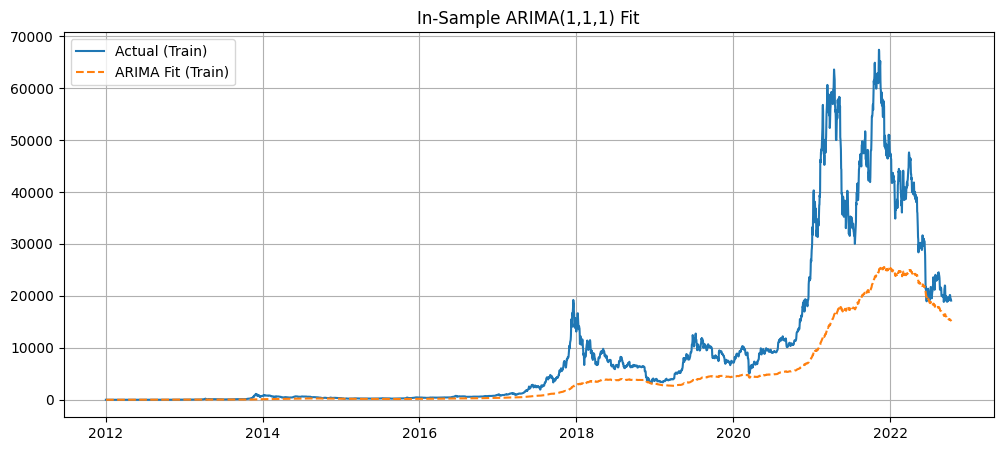

In [78]:
plt.figure(figsize=(12, 5))
plt.plot(df_features['Close'].iloc[1:len(forecast_prices_train)+1], label='Actual (Train)')
plt.plot(forecast_prices_train.index, forecast_prices_train.values, label='ARIMA Fit (Train)', linestyle='--')
plt.title('In-Sample ARIMA(1,1,1) Fit')
plt.legend()
plt.grid()
plt.show()

## Model Building II: LSTM

In [53]:
df_lstm = df_features.copy()
df_lstm.dropna(inplace=True)

### Step 1: Prepare the training and testing data by creating sequences

In [63]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit separately
scaled_features = feature_scaler.fit_transform(df_lstm)
scaled_target = target_scaler.fit_transform(df_lstm[['Close']])

def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X, y = create_sequences(scaled_features, scaled_target, time_steps)


X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]

### Step 2: Configure and create the model

In [64]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,873 (155.75 KB)

 Trainable params: 39,873 (155.75 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training and Prediction

In [65]:
# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.1, callbacks=[early_stop], verbose=1)

# Predict and inverse scale
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 4.4694e-04
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6045e-04 - val_loss: 4.2374e-04
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8174e-04 - val_loss: 3.6365e-04
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6239e-04 - val_loss: 2.7195e-04
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4366e-04 - val_loss: 2.9378e-04
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2364e-04 - val_loss: 5.0366e-04
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3011e-04 - val_loss: 9.6096e-04
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2583e-04 - val_loss: 3.9685e-04
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2141e-04 - val_loss: 4.5270e-04
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6227e-04 - val_loss: 4.4611e-04
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

### Step 4: Accuracy Analysis

Test MAE: 4205.69
Test MAPE: 5.44%


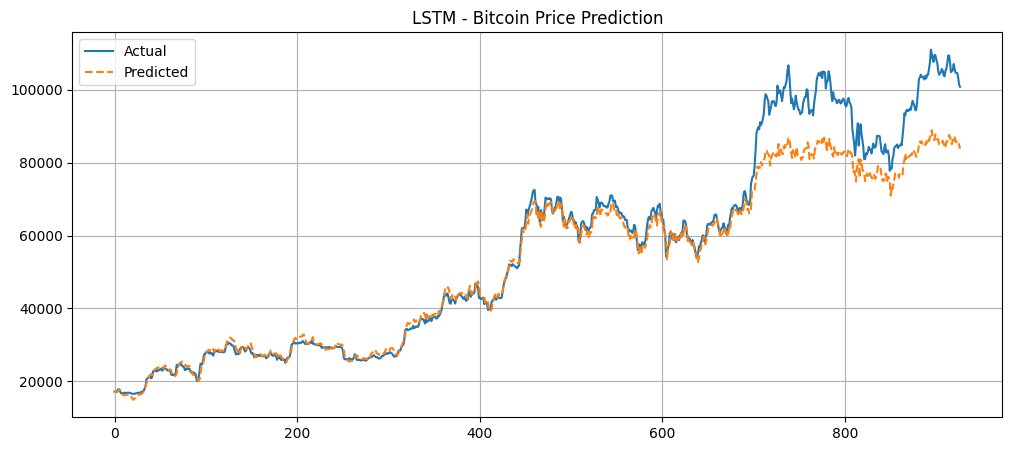

In [66]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print(f"Test MAE: {mae:.2f}")
print(f"Test MAPE: {mape:.2%}")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title("LSTM - Bitcoin Price Prediction")
plt.legend()
plt.grid()
plt.show()

The LSTM does really well on unseen test data, much lower error values compared to ARIMA. This is because LSTM uses a lot more features to better predict the price movement of the asset, and it also can learn non-linear relationships really well. We can experiment with hyperparameter tuning to change the sequence length , dropout rate, and even the layers and number of neurons to check if we can get a better model.
Currently we use a 30 day sequence window since a month is a reasonable time to capture relevant patterns and sudden price movements. 
The dropout rate is 20% for the LSTM for adding noise to the data and to prevent it from overfitting. It is sort of a regularizer for the model that randomly drops 20% of the output during training.
The reduction of neurons in the second LSTM layer from 64 to 32 helps compress and capture the essential information in the data, and reducing the neurons help reduce overfitting.
The final fully connected layer with RelU is for nonlinear transformation and feature mixing.